# DeepHyper 101

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deephyper/tutorials/blob/main/tutorials/colab/DeepHyper_101.ipynb)


In this tutorial, we present the basics of DeepHyper.

Let us start with installing DeepHyper!

In [ ]:
!pip install deephyper
!pip install ray==1.9.2 -I

<div class="alert alert-warning">

<b>Warning</b>
    
By design asyncio does not allow nested event loops. Jupyter is using Tornado which already starts an event loop. Therefore the following patch is required to run DeepHyper in a Jupyter notebook.
    
</div>

In [ ]:
!pip install nest_asyncio

import nest_asyncio
nest_asyncio.apply()

## Optimization Problem

In the definition of our optimization problem we have two components:

1. black-box function that we want to optimize
2. the search space of input variables

### Black-Box Function

DeepHyper is developed to optimize black-box functions. Here, we define the function $f(x) = - x ^ 2$ that we want to maximise (the maximum being $f(x=0) = 0$ on $I_x = [-10;10]$). The black-box function `f` takes as input a `config` dictionnary from which we retrieve the variables of interest.

In [11]:
def f(config):
    return - config["x"]**2

### Search Space of Input Variables

In this example, we have only one variable $x$ for the black-box functin $f$. We empirically decide to optimize this variable $x$ on the interval $I_x = [-10;10]$. To do so we use the `HpProblem` from DeepHyper and add a **real** hyperparameter by using a `tuple` of two `floats`.

In [ ]:
from deephyper.problem import HpProblem


problem = HpProblem()

# define the variable you want to optimize
problem.add_hyperparameter((-10.0, 10.0), "x")

problem

Configuration space object:
  Hyperparameters:
    x, Type: UniformFloat, Range: [-10.0, 10.0], Default: 0.0

## Evaluator Interface

DeepHyper uses an API called `Evaluator` to distribute the computation of black-box functions and adapt to different backends (e.g., threads, processes, MPI, Ray). An `Evaluator` object wraps the black-box function `f` that we want to optimize. Then a `method` parameter is used to select the backend and `method_kwargs` defines some available options of this backend. For Jupyter notebooks we use the Ray evaluator (`method="ray"`).

Depending on available resources (`num_cpus`) available and the quantity of resources used by each computation of the black-box function (`num_cpus_per_task`) the number of available workers is automatically computed.

It is possible to define callbacks to extend the behaviour of `Evaluator` each time a function-evaluation is launched or completed. In this example we use the `LoggerCallback` to follow the completed evaluations and the evolution of the objective.

In [14]:
from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import LoggerCallback


# define the evaluator to distribute the computation
evaluator = Evaluator.create(
    f,
    method="ray",
    method_kwargs={
        "num_cpus": 1,
        "num_cpus_per_task": 0.25,
        "callbacks": [LoggerCallback()]
    },
)

print(f"Evaluator has {evaluator.num_workers} available worker{'' if evaluator.num_workers == 1 else 's'}")

Evaluator has 4 available workers


## Search Algorithm

The next step is to define the search algorithm that we want to use. Here, we choose `AMBS` (Asynchronous Model-Based Search) which is a sampling based Bayesian optimization strategy. This algorithm has the advantage of being asynchronous thanks to a constant liar strategy which is crutial to keep a good utilization of the resources when the number of available workers increases.

In [15]:
from deephyper.search.hps import AMBS


# define your search
search = AMBS(problem, evaluator)

Then, we can execute the search for a given number of iterations by using the `search.search(max_evals=...)`. It is also possible to use the `timeout` parameter if one needs a specific time budget (e.g., restricted computational time in machine learning competitions, allocation time in HPC).

In [16]:
results = search.search(max_evals=100)

[00001] -- best objective: -48.01665 -- received objective: -48.01665
[00002] -- best objective: -32.48806 -- received objective: -32.48806
[00003] -- best objective: -6.95366 -- received objective: -6.95366
[00004] -- best objective: -0.02131 -- received objective: -0.02131
[00005] -- best objective: -0.02131 -- received objective: -6.22327
[00006] -- best objective: -0.02131 -- received objective: -6.66244
[00007] -- best objective: -0.02131 -- received objective: -23.36765
[00008] -- best objective: -0.02131 -- received objective: -18.95907
[00009] -- best objective: -0.02131 -- received objective: -16.40159
[00010] -- best objective: -0.02131 -- received objective: -9.62992
[00011] -- best objective: -0.02131 -- received objective: -17.61847
[00012] -- best objective: -0.02131 -- received objective: -24.02175
[00013] -- best objective: -0.02131 -- received objective: -8.78387
[00014] -- best objective: -0.02131 -- received objective: -1.66473
[00015] -- best objective: -0.02131 -- 

Finally, let us visualize the results. The `search(...)` returns a DataFrame also saved locally under `results.csv` (in case of crash we don't want to loose the possibly expensive evaluations already performed). 

The DataFrame contains as columns:
1. the optimized hyperparameters: such as `x` in our case.
2. the `id` of each evaluated function (increased incrementally following the order of created evaluations).
3. the `objective` maximised which directly match the results of the $f$-function in our example.
4. the time of termination of each task `elapsed_sec` (in secondes, since the creation of the `Evaluator`) and the `duration` (in secondes).

In [17]:
results

,x,id,objective,elapsed_sec,duration
0,6.929404,1,-48.016645,18.691893,0.015289
1,-5.699830,2,-32.488058,19.265710,0.589085
2,-0.145986,3,-0.021312,19.267566,0.590926
3,-2.636978,4,-6.953655,19.266957,0.590303
4,2.494648,5,-6.223271,20.655589,1.391588
...,...,...,...,...,...
93,-0.007204,94,-0.000052,76.526612,1.072505
94,-0.017661,96,-0.000312,76.526468,1.072291
95,-0.017504,97,-0.000306,78.039819,1.515123
96,0.001946,95,-0.000004,76.528772,1.074623


We can also plot the evolution of the objective to verify that we converge correctly toward $0$.

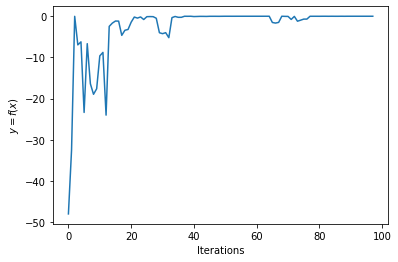

In [21]:
import matplotlib.pyplot as plt

plt.plot(results.objective)

plt.xlabel("Iterations")
plt.ylabel("$y = f(x)$")

plt.show()